# **Sri Sai Ravi Charan Siddabathuni - 21BAI1918**



# **Neural Machine Translation using GRU model with Bahdanau attention mechanism**

---

In [1]:
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2.15.0


# **Load Dataset**

*   Clean the sentences by removing special characters.
*   Add a start and end token to each sentence.
*   Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
*   Pad each sentence to a maximum length.

In [2]:
# Downloading the file
# get_file is to download files from a given URL and cache them in the TensorFlow data directory, returning the path to the downloaded file
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 1s 0us/step


In [3]:
# Converts the unicode file to ascii to remove accent marks
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  # Converts the sentence to lowercase and strips leading and trailing whitespace
  w = unicode_to_ascii(w.lower().strip())

  # Adding space before and after punctuation characters like ".", "?", "!", "," and "¿" to ensure they are treated as separate tokens during tokenization
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",","¿")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  # remove extra space
  w = w.strip()

  # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
en_sentence = u"May I borrow this @ book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

# UTF-8 is an encoding system for Unicode. It can translate any Unicode character to a matching unique binary string, and can also translate the binary string back to a Unicode character.
# This is the meaning of “UTF”, or “Unicode Transformation Format.”
print(preprocess_sentence(sp_sentence).encode("UTF-8"))

<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  # source target pair separated by a tab space
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  # source and target zipped as pairs
  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])
print(len(en), len(sp))

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
118964 118964


In [6]:
# Tokenizing the sentence into list of words(integers) and pad the sequence to the same length
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  # zeros are added after the actual sequence tokens to ensure uniform length
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [7]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# input_tensor: Tokenized and padded sequences for the input language.
# inp_lang_tokenizer: Tokenizer object for the input language.


In [8]:
# Taking 'x' number of rows into consideration for training the model
num_examples = 70000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# max_length of the target and input tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

14 20


In [9]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
# 70,000 x 0.8 = 56,000
# 70,000 x 0.2 = 14,000
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

# NumPy arrays containing the tokenized and padded sequences for the input and target languages, respectively. Each row represents a sequence and each number in the row represents a token.
print(input_tensor_train[0])
print(target_tensor_train[0])

56000 56000 14000 14000
[    1    29  2717    18 15339    11   430     3     2     0     0     0
     0     0     0     0     0     0     0     0]
[   1   42  451   23 2707   52  545    3    2    0    0    0    0    0]


In [10]:
print(inp_lang)
print(targ_lang)

In [11]:
print("Input Language Word Index:")
print(inp_lang.word_index)

print("\nTarget Language Word Index:")
print(targ_lang.word_index)

Input Language Word Index:
{'<start>': 1, '<end>': 2, '.': 3, '?': 4, '¿': 5, 'tom': 6, 'el': 7, 'no': 8, 'que': 9, 'a': 10, 'de': 11, 'es': 12, 'la': 13, 'un': 14, 'me': 15, 'en': 16, 'esta': 17, 'se': 18, 'lo': 19, 'por': 20, 'una': 21, 'mi': 22, 'te': 23, 'ella': 24, 'le': 25, ',': 26, 'los': 27, 'tu': 28, 'su': 29, 'con': 30, 'yo': 31, 'estoy': 32, 'eso': 33, 'las': 34, 'mary': 35, 'muy': 36, 'tiene': 37, 'tengo': 38, 'como': 39, 'aqui': 40, 'para': 41, 'esto': 42, 'mas': 43, 'quiero': 44, 'al': 45, 'puedo': 46, 'este': 47, 'gusta': 48, '!': 49, 'estaba': 50, 'fue': 51, 'favor': 52, 'casa': 53, 'son': 54, 'estas': 55, 'donde': 56, 'tomas': 57, 'y': 58, 'solo': 59, 'ellos': 60, 'quien': 61, 'todos': 62, 'soy': 63, 'ha': 64, 'todo': 65, 'algo': 66, 'bien': 67, 'he': 68, 'hacer': 69, 'ahora': 70, 'puede': 71, 'ir': 72, 'nada': 73, 'tan': 74, 'nos': 75, 'estan': 76, 'era': 77, 'tienes': 78, 'mucho': 79, 'hay': 80, 'ya': 81, 'trabajo': 82, 'nunca': 83, 'eres': 84, 'tiempo': 85, 'ser': 8

In [12]:
# Pickle files are a way to serialize and deserialize Python objects. Serialization is the process of converting a Python object into a byte stream, which can be saved to a file or transmitted over a network.
# Deserialization is the reverse process, where the byte stream is converted back into a Python object.

import pickle

# Saving the Tokenizer objects
with open('inp_lang_tokenizer.pkl', 'wb') as f:
    pickle.dump(inp_lang, f)

with open('targ_lang_tokenizer.pkl', 'wb') as f:
    pickle.dump(targ_lang, f)

print("Download links:")
print("Input Language Tokenizer: <a href='inp_lang_tokenizer.pkl' download>Download</a>")
print("Target Language Tokenizer: <a href='targ_lang_tokenizer.pkl' download>Download</a>")


Download links:
Input Language Tokenizer: <a href='inp_lang_tokenizer.pkl' download>Download</a>
Target Language Tokenizer: <a href='targ_lang_tokenizer.pkl' download>Download</a>


# **Create a tf.data dataset**

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:


*   Create a source dataset from your input data.
*   Apply dataset transformations to preprocess the data.
*   Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [13]:
# Configuration
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

# 56,000 / 64 = 875
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
# 14,000 / 64 = 218.75
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE

embedding_dim = 256  # for word embedding
units = 1024  # dimensionality of the output space of RNN

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE) #shuffling data
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # remaining examples that don't fit into a full batch are dropped
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 20]), TensorShape([64, 14]))

# **Basic seq2seq model: encoder and decoder**

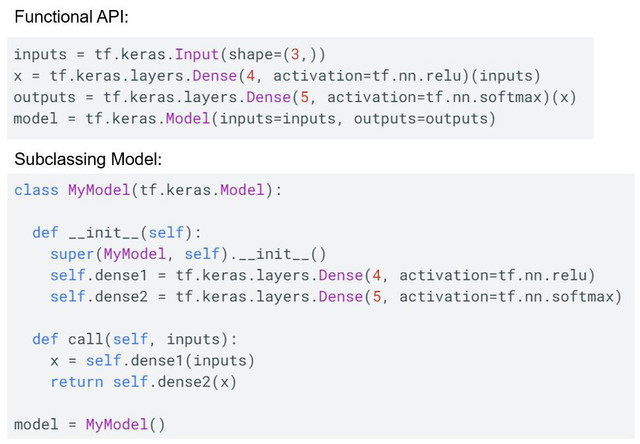

seq2seq with attention:![image.png](https://lena-voita.github.io/resources/lectures/seq2seq/attention/attn_for_steps/6-min.png)

In [14]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,  # Whether to return the last output in the output sequence or the full sequence.
                                   return_state=True,  # Whether to return the last state in addition to the output.
                                   recurrent_initializer='glorot_uniform') # Xavier initialization - samples weights from a uniform distribution with a certain range
  # forward pass of the encoder
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  # initializes the hidden state of the GRU layer with zeroes
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


# Encoder class initializes an Encoder object with an embedding layer and a GRU layer. It embeds input sequences and passes them through the GRU layer returning both the output sequence
# and the final hidden state. The hidden state is initialized with zeros.
# This class is a crucial component of the sequence-to-sequence model responsible for encoding input sequences into a fixed size representation.

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


# **Decoder without attention:**

In [16]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  # forward pass of the decoder
  def call(self, x, hidden):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2])) # flattening and passing it to the dense layer

    # output shape == (batch_size, vocab)
    x = self.fc(output) # after passing the flattened ouput through the dense layer, predicted probabilities for the next token in the output sequence are obtained
    return x, state

# Decoder class takes input token indices, processes them through an embedding layer and a GRU layer and produces output probabilities for the next token in the output sequence.
# It plays a crucial role in generating the target sequences during training and inference in a seq2seq model.

In [17]:
tf.reshape([[1,2,3],[4,5,6]], (-1, 2))

# The reshaping operation is essential to prepare the output sequence from the GRU layer for processing by the Dense layer in the Decoder.
# It ensures that the output sequence is in the correct shape for generating the predicted probabilities for the next token in the output sequence.

# output sequence from the GRU layer (output) has a shape of (batch_size, sequence_length, units)
# Dense layer expects its input to be in the shape (batch_size, features)
# To pass the output sequence through the Dense layer, it needs to be reshaped into a 2D tensor where each row corresponds to one step in the sequence and each column corresponds to one unit in the output.
# Reshaping it into (batch_size * sequence_length, units) effectively flattens the output sequence while preserving the information of each step and unit.

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4],
       [5, 6]], dtype=int32)>

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8479)


![alt text](https://i.ibb.co/BqDYNP1/additive.jpg)

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # A Dense layer that maps the encoder hidden states to a new space with dimensionality units
    self.W2 = tf.keras.layers.Dense(units) # Another Dense layer that maps the decoder hidden state (query) to the same space with dimensionality units
    self.V = tf.keras.layers.Dense(1) # A final Dense layer with a single unit used to compute the attention scores

  # forward pass of attention layer
  # query: The decoder hidden state at the current time step (query)
  # values: The encoder hidden states representing the entire input sequence

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1) # Adds a time axis to the query tensor to match the shape of the values tensor for compatibility in subsequent operations

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))
    # Computes the attention scores by applying a feedforward neural network to both the encoder hidden states (values)
    # and the decoder hidden state (query). The tanh activation function is applied to the sum of the transformed values and query

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Reduces the context vector across the time axis by summing over all encoder time steps resulting in a single context vector representing the attended information from the input sequence

    return context_vector, attention_weights

# **Decoder with attention:**

In [20]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer = None): # compute attention weights during decoding
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = attention_layer # Stores the attention mechanism layer provided as an argument

  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    attention_weights = None

    if self.attention:
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)
      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights


  # DecoderWithAttention class extends the basic Decoder class to incorporate an attention mechanism during decoding.
  # It enables the decoder to focus on different parts of the input sequence dynamically during each decoding step improving the model's ability to generate accurate translations or predictions.

In [21]:
# loss_function computes the Sparse Categorical Crossentropy loss between the true target sequences and the predicted sequences taking into account padding tokens.
# It ensures that the model is trained to generate correct predictions for non-padded tokens while ignoring the padded tokens during the loss calculation.

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # loss for each sequence element will be computed separately and not averaged across the batch

# computes the loss between the true target sequence (real) and the predicted sequence (pred)
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # creates a mask to ignore padding tokens (tokens with value 0) in the target sequences
  loss_ = loss_object(real, pred) # calculates the cross-entropy loss
  mask = tf.cast(mask, dtype=loss_.dtype) # casts the mask to the same data type as the computed loss.
  loss_ *= mask # applies the mask to the computed loss
  return tf.reduce_mean(loss_)

In [22]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))
print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


In [23]:
optimizer = tf.keras.optimizers.Adam()

def get_train_step_func():

  @tf.function # decorator provided by TensorFlow that compiles the function into a TensorFlow graph which can improve performance by optimizing the computation and reducing overhead
  def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape: # for automatic differentiation
      enc_output, enc_hidden = encoder(inp, enc_hidden) # Passes the input sequence through the encoder to obtain the encoder output and hidden state

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1) # Initializes the decoder input (dec_input) with the start token <start>

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

  return train_step


# Teacher forcing loop:
# For each time step in the target sequence (targ.shape[1]):
# Passes the encoder output and decoder input to the decoder to obtain predictions for the next token.
# Computes the loss between the predicted tokens and the actual tokens using the defined loss function (loss_function).
# Updates the decoder input with the actual token from the target sequence for the next time step.



# the training step function performs one step of training by computing the forward pass, loss, gradients and parameter updates using the Adam optimizer. It utilizes teacher forcing during training,
# where the actual target tokens are fed as inputs to the decoder at each time step. The function returns the average loss per token for the batch.

# **Define Loss Function**

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.
![alt text](https://i.ibb.co/GtD1vc9/cross-entropy.png)

In [24]:
def caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1) # decoder input is initialized with the start token <start> for all sequences in the batch

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss / int(targ.shape[1]) # After the loop the accumulated loss is divided by the length of the target sequences to compute the average loss per token
  return loss

In [25]:
def training_seq2seq(epochs, attention):
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
  decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
  train_step_func = get_train_step_func()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder) # computing batch loss
      total_loss += batch_loss # total loss for epoch by accumulating the batch loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss)) # displaying batch loss

    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0
    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch)):# computing validation loss
      val_loss = caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss / steps_per_epoch)
    validation_loss.append(total_val_loss / steps_per_epoch_val)
    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1, training_loss[-1], validation_loss[-1])) # displaying epoch loss and validation loss
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  return encoder, decoder, training_loss, validation_loss

# **Training seq2seq with Bahdanau attention**

In [26]:
epochs = 8

attention = BahdanauAttention(units)
print("Running seq2seq model with Bahdanau attention")
encoder_bah, decoder_bah, training_loss, validation_loss = training_seq2seq(epochs, attention)

Running seq2seq model with Bahdanau attention
Epoch 1 Batch 0 Loss 4.4927
Epoch 1 Batch 100 Loss 2.2929
Epoch 1 Batch 200 Loss 1.9521
Epoch 1 Batch 300 Loss 1.7718
Epoch 1 Batch 400 Loss 1.6712
Epoch 1 Batch 500 Loss 1.5269
Epoch 1 Batch 600 Loss 1.3759
Epoch 1 Batch 700 Loss 1.4107
Epoch 1 Batch 800 Loss 1.3415
Epoch 1 Loss 1.7202 Validation Loss 1.2239
Time taken for 1 epoch 161.94732856750488 sec

Epoch 2 Batch 0 Loss 1.1556
Epoch 2 Batch 100 Loss 0.9287
Epoch 2 Batch 200 Loss 0.9797
Epoch 2 Batch 300 Loss 0.9940
Epoch 2 Batch 400 Loss 1.0620
Epoch 2 Batch 500 Loss 0.8332
Epoch 2 Batch 600 Loss 0.8809
Epoch 2 Batch 700 Loss 0.8073
Epoch 2 Batch 800 Loss 0.8497
Epoch 2 Loss 0.9300 Validation Loss 0.8160
Time taken for 1 epoch 141.48354697227478 sec

Epoch 3 Batch 0 Loss 0.5181
Epoch 3 Batch 100 Loss 0.5177
Epoch 3 Batch 200 Loss 0.5638
Epoch 3 Batch 300 Loss 0.5178
Epoch 3 Batch 400 Loss 0.5533
Epoch 3 Batch 500 Loss 0.5417
Epoch 3 Batch 600 Loss 0.5181
Epoch 3 Batch 700 Loss 0.3974


Dimensions: ![img](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*AXRMD6MxpHdXqpTt4cSXiw.gif)

# **Plotting Training and Validation Loss**

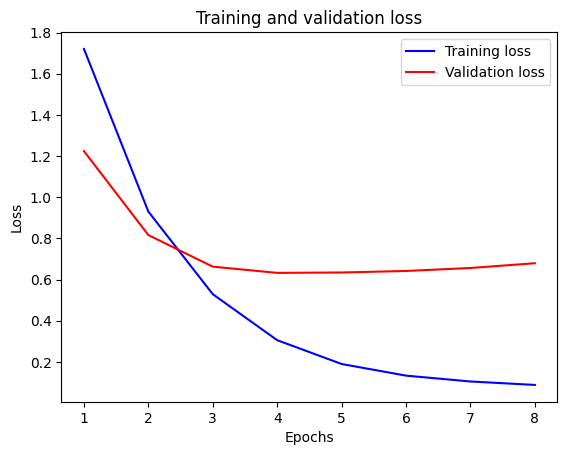

In [27]:
import matplotlib.pyplot as plt

# Assuming training_loss and validation_loss are lists or arrays containing loss values for each epoch

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Translation**

In [48]:
def translate(sentence, encoder, decoder):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # preprocessing
  sentence = preprocess_sentence(sentence)

  # tokenization
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out) # Passes the decoder input, decoder hidden state and encoder output to the decoder to obtain predictions for the next token

    attention_weights = tf.reshape(attention_weights, (-1,))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy() # Selects the token with the highest probability as the predicted token

    result += targ_lang.index_word[predicted_id] + ' ' # Appends the predicted token to the result string.

    # until the predicted word is <end>.
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model, no teacher forcing.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot



# Translate function takes an input sentence, preprocesses it, tokenizes it and generates the translation using the trained encoder and decoder models.
# The function utilizes the seq2seq model's inference mechanism to predict the next token in the target language sequence iteratively until the end token is encountered.


# In translate function, there is no teacher forcing during prediction because during inference or prediction time the model does not have access to the ground truth target sequence.
# Teacher forcing is a technique used during training where the model is fed the actual target sequence tokens at each time step encouraging it to learn the correct output sequence.

# **Prediction**

In [49]:
result, sentence, _ = translate(u'esta es mi vida.', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


In [32]:
result, sentence, _ = translate(u'¿Cómo está usted?', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> ¿ como esta usted ? <end>
Predicted translation: how do you do ? <end> 


In [33]:
result, sentence, _ = translate(u'mi nombre es', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> mi nombre es <end>
Predicted translation: my name is familiar . <end> 


# **Attention Maps on a Pair of Test Sample Source & Target Text**

Attention maps identify which parts of the input sequence are most influential in generating specific parts of the output sequence

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(attention, input_sentence, output_sentence):
    fig = plt.figure(figsize=(10, 10))

    # Split input and output sentences into words.
    input_words = input_sentence.split()
    output_words = output_sentence.split()

    # Attention weights for each word in the output sentence.
    attention_weights = attention[:len(output_words), :len(input_words)]

    # Plot the attention weights.
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention_weights, cmap='viridis')

    # Set the labels.
    ax.set_xlabel('Input sentence')
    ax.set_ylabel('Output sentence')

    # Set the title.
    ax.set_title('Attention weights')

    # Set the ticks.
    ax.set_xticks(np.arange(len(input_words)))
    ax.set_yticks(np.arange(len(output_words)))

    # Set the labels for the ticks.
    ax.set_xticklabels(input_words, rotation=90)
    ax.set_yticklabels(output_words)

    # Show the colorbar.
    plt.colorbar(cax)

    # Show the plot.
    plt.show()


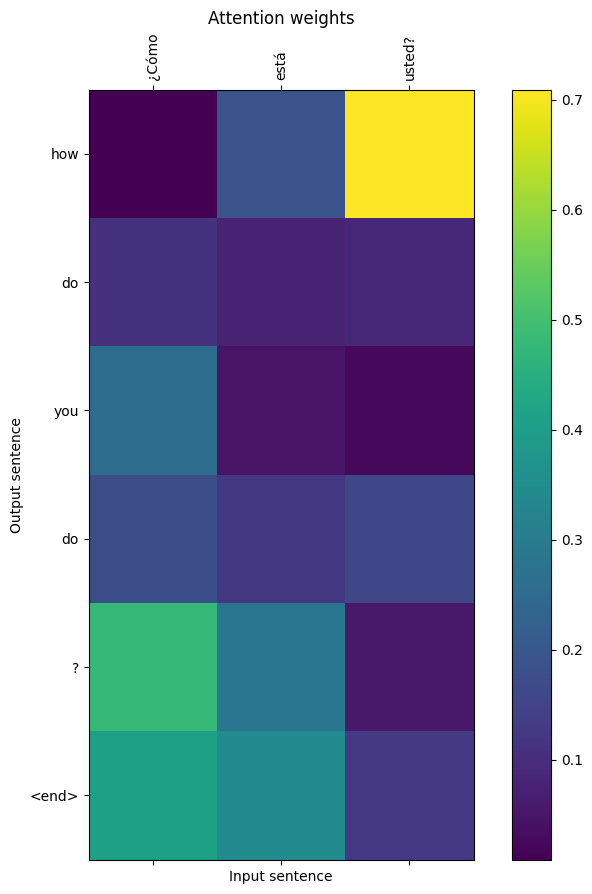

In [35]:
# Getting the attention weights for a sample sentence.
sentence = u'¿Cómo está usted?'
predicted_sentence, source, attention_weights = translate(sentence, encoder_bah, decoder_bah)

# Plotting the attention weights.
plot_attention(attention_weights, sentence, predicted_sentence)


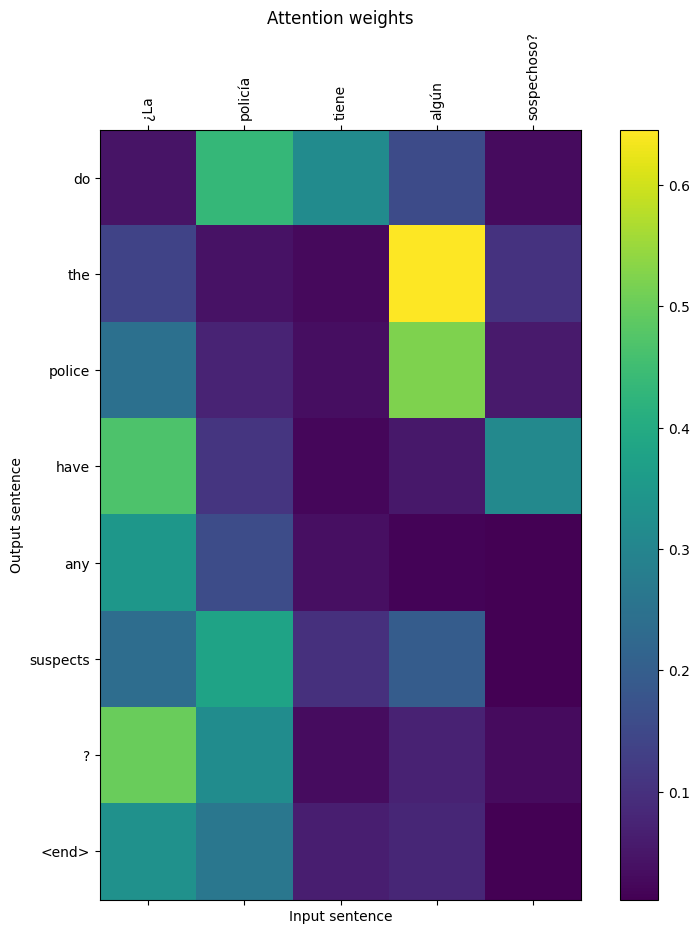

In [36]:
sentence = u'¿La policía tiene algún sospechoso?'
predicted_sentence, source, attention_weights = translate(sentence, encoder_bah, decoder_bah)

plot_attention(attention_weights, sentence, predicted_sentence)

# **CORPUS BLEU score for 10, 100, 1000, 10000 random samples from the first 70000 samples present in the dataset**

In [81]:
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Initialize lists to store references and hypotheses
list_of_references = []
list_of_hypotheses = []

# Get 100 random indices from the first 70000 samples
random_indices = random.sample(range(70000), 10)

for i in random_indices:
    en_sentence = en[i].replace('<start> ', '')  # Assuming en is your English sentences list
    sp_sentence = sp[i].replace('<start>', '').replace('<end>', '').strip()  # Assuming sp is your Spanish sentences list

    # Translate the Spanish sentence to English
    predicted_sentence, _, _ = translate(sp_sentence, encoder_bah, decoder_bah)

    # Append the reference and hypothesis for this sentence pair
    list_of_references.append([en_sentence.split()])
    list_of_hypotheses.append(predicted_sentence.split())

# Compute corpus BLEU score
corpus_bleu_score = corpus_bleu(list_of_references, list_of_hypotheses)

print(list_of_references)
print(list_of_hypotheses)

print(f"Corpus BLEU score: {corpus_bleu_score}")


[[['write', 'down', 'your', 'name', 'here', '.', '<end>']], [['is', 'he', 'american', '?', '<end>']], [['lend', 'me', 'your', 'knife', ',', 'please', '.', '<end>']], [['i', 'don', 't', 'want', 'tom', 'at', 'my', 'party', '.', '<end>']], [['tom', 'still', 'has', 'to', 'pay', 'the', 'bill', '.', '<end>']], [['they', 'are', 'ignorant', 'of', 'the', 'rules', '.', '<end>']], [['i', 'm', 'never', 'at', 'home', 'on', 'sundays', '.', '<end>']], [['i', 'can', 't', 'hear', 'anything', 'at', 'all', '.', '<end>']], [['my', 'friend', 'is', 'studying', 'korean', '.', '<end>']], [['tom', 'is', 'on', 'pain', 'killers', '.', '<end>']]]
[['write', 'down', 'your', 'name', 'here', '.', '<end>'], ['is', 'he', 'american', '?', '<end>'], ['please', 'lend', 'me', 'your', 'knife', '.', '<end>'], ['i', 'don', 't', 'want', 'tom', 'at', 'my', 'party', '.', '<end>'], ['tom', 'still', 'has', 'to', 'pay', 'the', 'bill', '.', '<end>'], ['they', 'are', 'ignorant', 'of', 'the', 'rules', '.', '<end>'], ['i', 'm', 'never

In [82]:
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Initialize lists to store references and hypotheses
list_of_references = []
list_of_hypotheses = []

# Get 100 random indices from the first 70000 samples
random_indices = random.sample(range(70000), 100)

for i in random_indices:
    en_sentence = en[i].replace('<start> ', '')  # Assuming en is your English sentences list
    sp_sentence = sp[i].replace('<start>', '').replace('<end>', '').strip()  # Assuming sp is your Spanish sentences list

    # Translate the Spanish sentence to English
    predicted_sentence, _, _ = translate(sp_sentence, encoder_bah, decoder_bah)

    # Append the reference and hypothesis for this sentence pair
    list_of_references.append([en_sentence.split()])
    list_of_hypotheses.append(predicted_sentence.split())

# Compute corpus BLEU score
corpus_bleu_score = corpus_bleu(list_of_references, list_of_hypotheses)

print(list_of_references)
print(list_of_hypotheses)

print(f"Corpus BLEU score: {corpus_bleu_score}")


[[['where', 's', 'tom', '?', '<end>']], [['nature', 'is', 'full', 'of', 'mystery', '.', '<end>']], [['it', 's', 'not', 'natural', '.', '<end>']], [['i', 'use', 'it', '.', '<end>']], [['i', 'was', 'scared', 'of', 'tom', '.', '<end>']], [['his', 'life', 'is', 'hanging', 'by', 'a', 'thread', '.', '<end>']], [['you', 'like', 'everyone', '.', '<end>']], [['that', 'chimney', 'is', 'very', 'high', '.', '<end>']], [['hi', ',', 'come', 'on', 'in', '.', '<end>']], [['we', 'captured', 'the', 'thief', '.', '<end>']], [['get', 'tom', 'on', 'it', '.', '<end>']], [['she', 'is', 'really', 'cute', '.', '<end>']], [['what', 's', 'your', 'relation', 'with', 'him', '?', '<end>']], [['that', 'was', 'cooked', 'in', 'oil', '.', '<end>']], [['this', 'is', 'delicious', '.', '<end>']], [['has', 'there', 'been', 'any', 'progress', '?', '<end>']], [['this', 'milk', 'has', 'a', 'peculiar', 'smell', '.', '<end>']], [['some', 'of', 'the', 'girls', 'laughed', '.', '<end>']], [['he', 'doesn', 't', 'want', 'it', '.', '

In [83]:
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Initialize lists to store references and hypotheses
list_of_references = []
list_of_hypotheses = []

# Get 100 random indices from the first 70000 samples
random_indices = random.sample(range(70000), 1000)

for i in random_indices:
    en_sentence = en[i].replace('<start> ', '')  # Assuming en is your English sentences list
    sp_sentence = sp[i].replace('<start>', '').replace('<end>', '').strip()  # Assuming sp is your Spanish sentences list

    # Translate the Spanish sentence to English
    predicted_sentence, _, _ = translate(sp_sentence, encoder_bah, decoder_bah)

    # Append the reference and hypothesis for this sentence pair
    list_of_references.append([en_sentence.split()])
    list_of_hypotheses.append(predicted_sentence.split())

# Compute corpus BLEU score
corpus_bleu_score = corpus_bleu(list_of_references, list_of_hypotheses)

print(list_of_references)
print(list_of_hypotheses)

print(f"Corpus BLEU score: {corpus_bleu_score}")


[[['tom', 'bet', 'on', 'the', 'race', '.', '<end>']], [['where', 'were', 'you', 'monday', 'night', '?', '<end>']], [['he', 'is', 'old', 'enough', 'to', 'drive', 'a', 'car', '.', '<end>']], [['memorize', 'it', '.', '<end>']], [['i', 'have', 'a', 'son', 'who', 's', 'sick', '.', '<end>']], [['tom', 'is', 'going', 'to', 'college', 'now', '.', '<end>']], [['she', 'looks', 'unhappy', '.', '<end>']], [['it', 'll', 'be', 'summer', 'vacation', 'soon', '.', '<end>']], [['tom', 'started', 'coughing', '.', '<end>']], [['i', 'know', 'i', 'have', 'a', 'biased', 'opinion', '.', '<end>']], [['it', 's', 'about', 'kilometers', 'away', '.', '<end>']], [['you', 'are', 'very', 'smart', '.', '<end>']], [['no', 'one', 'came', 'to', 'help', 'me', '.', '<end>']], [['we', 're', 'in', 'grave', 'danger', '.', '<end>']], [['she', 'woke', 'up', 'on', 'her', 'own', '.', '<end>']], [['i', 'will', 'go', 'at', '.', '<end>']], [['have', 'a', 'snack', '.', '<end>']], [['do', 'you', 'have', 'anything', 'to', 'eat', '?', '

In [88]:
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Initialize lists to store references and hypotheses
list_of_references = []
list_of_hypotheses = []

# Get 100 random indices from the first 70000 samples
random_indices = random.sample(range(70000), 10000)

for i in random_indices:
    en_sentence = en[i].replace('<start> ', '')  # Assuming en is your English sentences list
    sp_sentence = sp[i].replace('<start>', '').replace('<end>', '').strip()  # Assuming sp is your Spanish sentences list

    # Translate the Spanish sentence to English
    predicted_sentence, _, _ = translate(sp_sentence, encoder_bah, decoder_bah)

    # Append the reference and hypothesis for this sentence pair
    list_of_references.append([en_sentence.split()])
    list_of_hypotheses.append(predicted_sentence.split())

# Compute corpus BLEU score
corpus_bleu_score = corpus_bleu(list_of_references, list_of_hypotheses)

print(list_of_references)
print(list_of_hypotheses)

print(f"Corpus BLEU score: {corpus_bleu_score}")


[[['she', 'has', 'a', 'lot', 'of', 'work', 'to', 'do', '.', '<end>']], [['he', 'came', 'back', 'again', '.', '<end>']], [['i', 'don', 't', 'dream', '.', '<end>']], [['tom', 'finally', 'got', 'his', 'wish', '.', '<end>']], [['it', 's', 'tom', 's', 'fault', '.', '<end>']], [['think', 'about', 'that', '.', '<end>']], [['i', 'gazed', 'at', 'the', 'sea', 'for', 'hours', '.', '<end>']], [['don', 't', 'forget', 'your', 'money', '.', '<end>']], [['she', 'became', 'a', 'great', 'artist', '.', '<end>']], [['we', 've', 'seen', 'nothing', '.', '<end>']], [['he', 'robbed', 'me', 'of', 'my', 'bag', '.', '<end>']], [['tom', 'hung', 'up', 'on', 'me', '.', '<end>']], [['i', 'want', 'that', 'bag', '.', '<end>']], [['i', 'love', 'tom', '.', '<end>']], [['i', 'don', 't', 'know', 'what', 'it', 'means', '.', '<end>']], [['school', 'starts', 'at', '.', '<end>']], [['i', 'found', 'it', 'on', 'the', 'street', '.', '<end>']], [['eggs', 'are', 'sold', 'by', 'the', 'dozen', '.', '<end>']], [['don', 't', 'let', 'g

# **Next Steps**

- Train on bigger dataset that involves longer sentences
- Bidirection Models
- Transformer
- Use MongoDB for making phrase book which is a log of all translations that user has made
- Incorporate CRUD operations